# Download the Dataset

In [1]:
# Mount local drive directory
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
BASE_DIR = os.path.join('/content','gdrive','My Drive','dataset-compost-net-versionB')

!ls gdrive/My\ Drive/dataset-compost-net-versionB

image  test_train_split.py


In [3]:
DATA_DIR = BASE_DIR+"/image"

os.chdir(DATA_DIR)
!ls

TRAINING_LOGS_FILE = "/tmp/training_logs.csv"
MODEL_SUMMARY_FILE = "/tmp/model_summary.txt"
TEST_FILE = "/tmp/test_file.txt"
MODEL_FILE = "/tmp/model.h5"

training_data_dir  = 'train/'
test_data_dir = 'test/'

labels.txt	    model.tflite		       save
mobilenet_plot.png  sarahnet_categorical_accuracy.png  test
model_plot.png	    sarahnet_loss.png		       train


In [4]:
# Hyperparams
 
IMAGE_WIDTH, IMAGE_HEIGHT = 400, 300
EPOCHS = 20
BATCH_SIZE = 8

# Imports

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
import tensorflow as tf
from tensorflow.python import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, ZeroPadding2D
from keras.layers.merge import concatenate

from keras.optimizers import RMSprop

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

from keras.callbacks import CSVLogger

!pip install livelossplot
from livelossplot import PlotLossesKeras

# Load the Data

# Preprocess the Data

In [7]:
# Data augmentation
training_data_generator = ImageDataGenerator(
  rescale = 1./255,
  validation_split=0.3)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [8]:
# Data Preparation
training_generator = training_data_generator.flow_from_directory(
  training_data_dir,
  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
  batch_size = BATCH_SIZE,
  class_mode='categorical',
  subset='training')
validation_generator = training_data_generator.flow_from_directory(
  training_data_dir,
  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
  batch_size = BATCH_SIZE,
  class_mode='categorical',
  subset='validation')
test_generator = test_data_generator.flow_from_directory(
  test_data_dir,
  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
  color_mode="rgb",
  batch_size = 1,
  class_mode="categorical",
  shuffle=True)

Found 1534 images belonging to 7 classes.
Found 653 images belonging to 7 classes.
Found 564 images belonging to 7 classes.


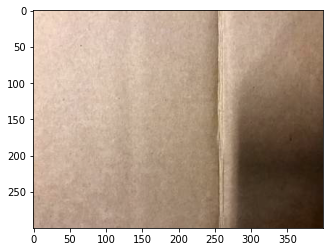

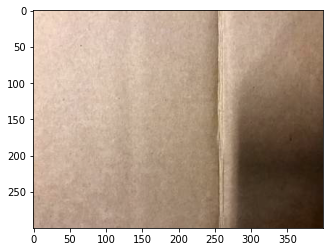

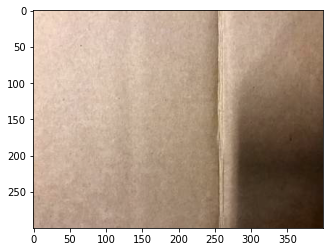

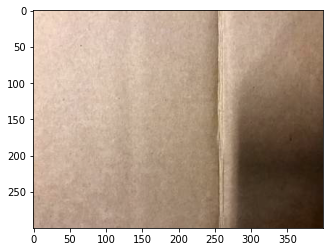

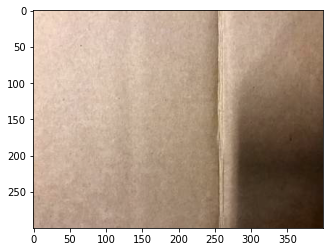

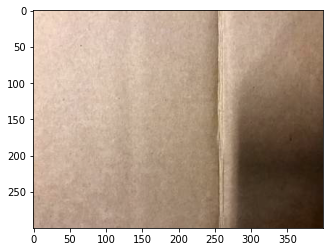

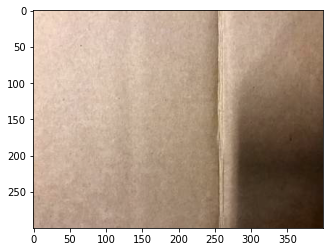

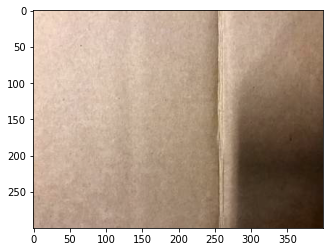

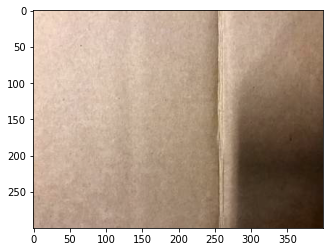

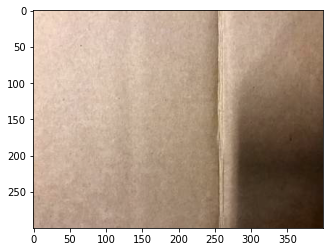

In [9]:
img = load_img('train/cardboard/cardboard2.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in training_data_generator.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 10 == 0:
    break

# The Model

In [10]:
def build_2convolutional_layer_model(width, height, layers):
  """ Builds a x3 CNN and add details later
      https://machinelearningmastery.com/keras-functional-api-deep-learning/
  """
  
  input = Input(shape=(width, height, layers))
  
  # first feature extractor
  conv1 = Conv2D(32, kernel_size=3, activation='relu')(input)
  conv2 = Conv2D(32, kernel_size=3, activation='relu')(conv1)
  pool1 = MaxPooling2D(pool_size=(2,2))(conv2)
  
  conv3 = Conv2D(64, 3, 3, activation='relu')(pool1)
  conv4 = Conv2D(64, 3, 3, activation='relu')(conv3)
  pool2 = MaxPooling2D(pool_size=(2,2))(conv4)
  
  conv5 = Conv2D(128, 3, 3, activation='relu')(pool2)
  conv6 = Conv2D(128, 3, 3, activation='relu')(conv3)
  pool3 = MaxPooling2D(pool_size=(2,2))(conv6)
  
  conv7 = Conv2D(256, 3, 3, activation='relu')(pool3)
  conv8 = Conv2D(256, 3, 3, activation='relu')(conv3)
  pool4 = MaxPooling2D(pool_size=(2,2))(conv8)
  
  flat = Flatten()(pool4)
  hidden1 = Dense(256, activation='relu')(flat)
  drop1 = Dropout(0.5)(hidden1)
  
  hidden2= Dense(256, activation='relu')(drop1)
  drop2 = Dropout(0.5)(hidden2)
  
  
  # prediction output
  output = Dense(1, activation='sigmoid')(drop2)
  
  model = Model(inputs=input, outputs=output)
  return model

In [11]:
def build_alex_net(width, height, layers):
  """ https://github.com/dhruvramani/keras-alexnet/blob/master/alexnet.py
  """
  
  input = Input(shape=(width, height, layers))
  
  # first convolution layer
  conv1 = Conv2D(64, 11, strides=4)(input)
  zeroPad1 = ZeroPadding2D(2)(conv1)
  active1 = Activation('relu')(zeroPad1)
  pool1 = MaxPooling2D(pool_size=3, strides=2)(active1)
  
  conv2 = Conv2D(192, 5)(pool1)
  zeroPad2 = ZeroPadding2D(2)(conv2)
  active2 = Activation('relu')(zeroPad2)
  pool2 = MaxPooling2D(pool_size=3, strides=2)(active2)
  
  conv3 = Conv2D(384, 3)(pool2)
  zeroPad3 = ZeroPadding2D(1)(conv3)
  active3 = Activation('relu')(zeroPad3)
  
  conv4 = Conv2D(256, 3)(active3)
  zeroPad4 = ZeroPadding2D(1)(conv4)
  active4 = Activation('relu')(zeroPad4)
  pool3 = MaxPooling2D(pool_size=3, strides=2)(active4)

  flat1 = Flatten()(pool3)
  drop1 = Dropout(0.5)(flat1)
  dense1 = Dense(4096, input_shape=(6 * 6 * 256, ))(drop1)
  active5 = Activation('relu')(dense1)
  drop2 = Dropout(0.5)(active5)
  dense2 = Dense(4096)(drop2)
  active6 =Activation('relu')(dense2)
  dense3 = Dense(7)(active6)
  active7 = Activation('softmax')(dense3)

  model = Model(inputs=input, outputs=active7)
  return model
  

In [12]:
def build_sarah_model(width, height, layers):
  """ yes
  """
  
  input = Input(shape=(width, height, layers))
  
  # first convolution layer
  conv1 = Conv2D(32, kernel_size=(3,3), activation='relu')(input)
  pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
  drop1 = Dropout(0.3)(pool1)
  
  # second convolution layer
  conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(drop1)
  pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
  drop2 = Dropout(0.3)(pool2)
  
  # third convolution layer
  conv3 = Conv2D(128, kernel_size=(3,3), activation='relu')(drop2)
  drop3 = Dropout(0.4)(conv3)
  flat3 = Flatten()(drop3)
  
  # dense layers
  dense1 = Dense(128, activation='relu')(flat3)
  drop4 = Dropout(0.3)(dense1)
  dense2 = Dense(7, activation='softmax')(drop4)
  
  return Model(inputs=input, outputs=dense2)

In [13]:
#model = build_2convolutional_layer_model(IMAGE_WIDTH, IMAGE_HEIGHT, 3)
# 287,731,009
#model = build_sarah_model(IMAGE_WIDTH, IMAGE_HEIGHT, 3)
model = build_alex_net(IMAGE_WIDTH, IMAGE_HEIGHT, 3)

'''tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

tpu_model.compile(
  optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
  loss = tf.keras.losses.sparse_categorical_crossentropy,
  metrics = ['sparse_categorical_accuracy']
)'''

from keras.optimizers import Adam
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),metrics=['categorical_accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 73, 64)        23296     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 102, 77, 64)       0         
_________________________________________________________________
activation (Activation)      (None, 102, 77, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 38, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 34, 192)       307392    
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 50, 38, 192)       0     

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_plot.png')
!ls
from google.colab import files
files.download('model_plot.png') 

labels.txt	    model.tflite		       save
mobilenet_plot.png  sarahnet_categorical_accuracy.png  test
model_plot.png	    sarahnet_loss.png		       train


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Training

In [16]:
# updatable plot
# a minimal example (sort of)

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

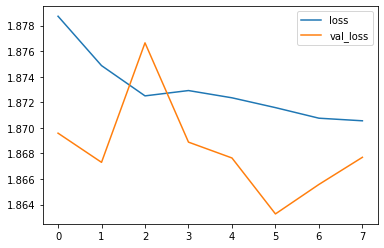

Epoch 9/20
 38/191 [====>.........................] - ETA: 6:10 - loss: 1.8519 - categorical_accuracy: 0.2303

In [ ]:
'''tpu_model.fit_generator(
  training_generator,
  steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=validation_generator,
  validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
  callbacks=[PlotLosses(), keras.callbacks.CSVLogger(TRAINING_LOGS_FILE,
                                         append=False,
                                         separator=";")],
  verbose=1)

tpu_model.save_weight(MODEL_FILE)'''
from IPython.display import clear_output

history = model.fit_generator(
  training_generator,
  steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=validation_generator,
  validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
  callbacks=[plot_losses, keras.callbacks.CSVLogger(TRAINING_LOGS_FILE,
                                         append=False,
                                         separator=";")],
  verbose=1)
model.save_weights(MODEL_FILE)

# Testing

In [ ]:
label_map = (test_generator.class_indices)
label_map

NameError: ignored

In [ ]:
open(TEST_FILE,"w")
STEP_SIZE_TEST=test_generator.n
probabilities = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)

print(probabilities[:3])

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)
nb_samples

In [ ]:
metrics = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print(model.metrics_names)
print(metrics)

#8571428656578064

In [ ]:
probabilities = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
print(probabilities)
print(len(probabilities))
import numpy as np
np.unique(probabilities, axis=0)
test_generator 

In [ ]:
test_generator.reset()
labels = ['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

paper_total = 0

for i in range(0,564):
  x,y = test_generator.next()
  if y.argmax(axis=-1)[0] == 4:
    paper_total += 1
paper_total/564


In [ ]:
test_generator.reset()
labels = ['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

for i in range(0,20):
  x,y = test_generator.next()
  image = x[0]
  plt.imshow(image)
  y_prob = model.predict(x)
  print(y_prob)
  y_classes = y_prob.argmax(axis=-1)
  plt.xlabel("Prediction: " + labels[y_classes[0]] + " Actual: " + labels[y.argmax(axis=-1)[0]])
  plt.show()